# Initialization

In [1]:
import os
import torch, pyro, numpy as np 

from clipppy.globals import register_globals
from clipppy import load_config
from clipppy.patches import torch_numpy
from ruamel.yaml import YAML

import matplotlib.pyplot as plt
imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5))

torch.cuda.set_device(0)
torch.set_default_tensor_type(torch.cuda.FloatTensor)

register_globals(**globals()) # clipppy magic

In [2]:
from plotting import plot_mult, test_import
import collections
import copy
# test_import(1)

### Load config

In [3]:
SYSTEM_NAME = "ngc4414"

os.makedirs(SYSTEM_NAME, exist_ok=True)
BASEDIR = os.path.join(SYSTEM_NAME) # only used for saving
os.makedirs(BASEDIR, exist_ok=True) # only used for saving

In [4]:
SOURCE_DIR = '../../mock_data/sources'
source_name = f'{SYSTEM_NAME}.npy'

config = load_config('config_gen_mock_lens.yaml', base_dir=SOURCE_DIR,
                     source_name=source_name) # clipppy magic

model = config.umodel # clippppy magic
guide = config.guide  # should play around with it

MASK = config.kwargs['defs']['mask']          # clipppy magic
NOISE = model.stochastic_specs['sigma_stat']  # noise is a spec of the stochastic process; clipppy magic
PARAMS = YAML().load(open('../paper-source/params.yaml'))[SYSTEM_NAME] # Real paramaters of system

In [5]:
# Only if we have the test 'config_gen_mock_test.yaml'
try:
    PARAMS['truth'] = collections.OrderedDict(config.kwargs['params']['truth'])
except:
    pass

# Generate mock data

#### Utilities

In [6]:
from skimage.transform import downscale_local_mean
from scipy.ndimage import filters
from pyrofit.lensing.utils import Converter

def get_mask(img, sigma=1., th=1.):
    """
    Generate mask
    """
    smooth = filters.gaussian_filter(img.numpy(), sigma=sigma)
    return smooth > th

#### Set image as source

In [7]:
imgsrc = config.kwargs['defs']['imagesrc']
model.sources = {'image': imgsrc}

imgsrc

#### True parameters for generating mock data

In [8]:
PARAMS['truth']

OrderedDict([('ext/gamma_1', 0.0443),
             ('ext/gamma_2', 0.0069),
             ('main/x', 0.0102),
             ('main/y', -0.0202),
             ('main/M', 10000000000000.0),
             ('main/c_200c', 20),
             ('main/tau', 5)])

#### Generate a 10nx x 10ny mock image and downsample it to create a mock image

X: x-coord

Y: y-coord

model.mask: noise 

In [9]:
UPSAMPLE = 10

# Save final grid
X, Y = model.X.clone(), model.Y.clone()


model.coerce_XY(*get_meshgrid(
    config.kwargs["defs"]["res"] / UPSAMPLE,
    config.kwargs["defs"]["nx"] * UPSAMPLE,
    config.kwargs["defs"]["ny"] * UPSAMPLE
))
model.mask = torch.full_like(model.X, True, dtype=bool, device="cuda:0")
model.stochastic_specs['sigma_stat'] *= UPSAMPLE

# plot_mult([X, Y, model.mask], 1, True)

 PARAMS['truth'] : 
 	 OrderedDict([('ext/gamma_1', 0.0443), ('ext/gamma_2', 0.0069), ('main/x', 0.0102), ('main/y', -0.0202), ('main/M', 10000000000000.0), ('main/c_200c', 20), ('main/tau', 5)]) 

{'gamma_1': 0.0443, 'gamma_2': 0.0069}
{'x': -0.0102, 'y': 0.0202, 'M': 10000000000000.0, 'c_200c': 20, 'tau': 5}


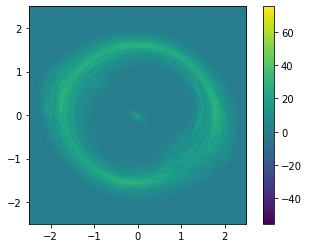

In [10]:
# parm_dict_upd = {'gamma_1' : 0.005,
#             'gamma_2' : 0.03,
#             'phi' : 1.0,
#             'q' : 0.75,
#             'r_ein' : 1.5,
#             'slope' : 2.1,
#             'x' : -0.5,
#             'y' : 0.1}

parm_dict_upd = {'gamma_1' : 0.0443,
            'gamma_2' : 0.0069,
            'x' : -0.0102,
            'y' : 0.0202,
            'M' : 1e13,
            'c_200c' : 20,
            'tau' : 5}

print(f" PARAMS['truth'] : \n \t {PARAMS['truth']} \n")


for lens in model.alphas:
    parm_dict_old = model.alphas[lens].stochastic_specs 
    for sub in parm_dict_old:
        if sub in parm_dict_upd:
            parm_dict_old[sub]  = parm_dict_upd[sub]
    model.alphas[lens].stochastic_specs = parm_dict_old  
    print(model.alphas[lens].stochastic_specs)
    

# plot_mult([model() for _ in range(3)], 1)
plt.imshow(model(), **imkwargs)
plt.colorbar()
plt.show()